## steps: 
1. get the sentence data from json

2. using ESGBERT - classify in 9 categories 

3. Keep only Environemtal sentences for GW (climate change, waste and pollution, natural capital)

4. using ESGBERT/EnvironmentalBERT-action classify sentences into **action** and non-action

5. using climatebert/environmental-claims classify into **claim** and non-claim

6. Get the **Net Action ratio** from action/claims 

7. This can be done for all reports in the dataset to determine a **benchmark**

8. Compare the Net Action ratio of a test report to the benchmark to determine GW potential

## import

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from tqdm.auto import tqdm

/Users/heenalpatel/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/heenalpatel/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## get data from json

In [2]:
def extract_sentence_lists(json_file):
    """
    Extracts all sentence_lists from a JSON file and returns them as a DataFrame.

    Args:
        json_file (str): Path to the JSON file.

    Returns:
        pandas.DataFrame: DataFrame containing all sentence lists.
    """

    with open(json_file, 'r') as f:
        data = json.load(f)

    all_sentences = []
    for item in data:
        if "sentence_list" in item:
            all_sentences.extend(item["sentence_list"])

    df = pd.DataFrame(all_sentences, columns=["sentence"])  # Assuming each sentence is a string
    return df

#for all reports in JSON:
# json_file_path = "output/pdf_data.json" 
# df = extract_sentence_lists(json_file_path)
# print(df)

### get particular report

In [6]:
with open("output/pdf_data.json", 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data[22]["sentence_list"], columns=["sentences"])  
df

,sentences
0,About this report The content and structure of...
1,Sustainability has become increasingly integra...
2,This sustainability report is aligned with our...
3,Featuring highlights from the reporting period...
4,"While this reports scope is FY 2023, some long..."
...,...
514,The key issues assessment provides a foundatio...
515,"To conduct the key issues assessment, we monit..."
516,"For the purpose of this Sustainability Report,..."
517,We use this independent analysis to better inf...


## classify into 9 cat

-- TO DO - w Kiana

## classify actions

In [3]:
def classify_actions(input_df):
    '''
    Classifies the actions in the input DataFrame using the EnvironmentalBERT-action model.

    Args:
        input_df (pandas.DataFrame): DataFrame containing the sentences to be classified.

    Returns:
        pandas.DataFrame: DataFrame with the following columns: 
            - sentence: The original sentence.
            - action_label: The predicted action label.
            - action_score: The confidence score of the predicted action label.
    '''
    
    tokenizer_name = "ESGBERT/EnvironmentalBERT-action"
    model_name = "ESGBERT/EnvironmentalBERT-action"
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, max_len=512)
    
    pipe_action = pipeline("text-classification", model=model, tokenizer=tokenizer)  # set device=0 to use GPU

    out_df = input_df.copy()
    out_df["action"] = out_df["sentences"].apply(lambda x: pipe_action(x, padding=True, truncation=True))

    out_df["action_label"] = out_df["action"].apply(lambda x: x[0]["label"])
    out_df["action_score"] = out_df["action"].apply(lambda x: x[0]["score"])
    #delete the action column
    out_df = out_df.drop(columns=["action"])

    return out_df


## classify claims

In [4]:
def classify_claims(input_df):
    '''
    Classifies the claims in the input DataFrame using the EnvironmentalBERT-claim model.

    Args:
        input_df (pandas.DataFrame): DataFrame containing the sentences to be classified.

    Returns:
        pandas.DataFrame: DataFrame with the following columns: 
            - sentence: The original sentence.
            - claim_label: The predicted claim label.
            - claim_score: The confidence score of the predicted claim label.
    '''
    model_name = "climatebert/environmental-claims"
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name, max_len=512)

    pipe_claim = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0)

    out_df = input_df.copy()
    out_df["claim"] = out_df["sentences"].apply(lambda x: pipe_claim(x, padding=True, truncation=True))
    out_df["claim_label"] = out_df["claim"].apply(lambda x: x[0]["label"])
    out_df["claim_score"] = out_df["claim"].apply(lambda x: x[0]["score"])
    out_df = out_df.drop(columns=["claim"])

    return out_df

## action + claim combine implementation

In [5]:
def classify_actions_claims(input_df):
    action_df = classify_actions(input_df)
    action_claim_df = classify_claims(action_df)

    return action_claim_df

In [ ]:
action_claim_df = classify_actions_claims(df)
action_claim_df

## potential GW

### net action ratio

In [7]:
def net_action_ratio(input_df):
    '''
    calculates a single net action score for the input DataFrame.  
    '''
    claim_ratio = input_df["claim_label"].value_counts(normalize=True)["yes"] 
    action_ratio = input_df["action_label"].value_counts(normalize=True)["action"]
    net_action_ratio = action_ratio - claim_ratio
    return net_action_ratio

In [ ]:
net_action = net_action_ratio(action_claim_df)
net_action

0.4585741811175337

### comparing 

In [ ]:
#for all the reports in the JSON file, calculate the net action score, and store it in a json file which 
# has the same structure as the input JSON file but with an additional key-value pair for the net action score.

def net_action_score(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    for item in data:
        df = pd.DataFrame(item["sentence_list"], columns=["sentences"])  
        action_claim_df = classify_actions_claims(df)
        na_score = net_action_ratio(action_claim_df)
        item["net_action_score"] = na_score
    with open('GW output/pdf_data.json', 'w') as f:
        json.dump(data, f) 

net_action_score("GW output/pdf_data.json")

Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0
Device set to use mps:0


In [20]:
#get the net action score and pdf path from the output JSON file and store it in a dataframe
net_action_scores = []
report = []
with open("output/pdf_data.json", 'r') as f:
    data = json.load(f)
    for item in data:
        report.append(item["pdf_path"])
        net_action_scores.append(item["net_action_score"])

df_scores_new = pd.DataFrame({"pdf_path": report, "net_action_score": net_action_scores})

In [21]:
#for pdf path in df_scores create a column report to extract the report name from the pdf path
df_scores_new["report"] = df_scores_new["pdf_path"].apply(lambda x: x.split("/")[-1].split(".")[0])

In [22]:
df_scores_new

,pdf_path,net_action_score,report
0,/Users/heenalpatel/Documents/esg_nlp/gw scores...,0.353198,NFE_2022
1,/Users/heenalpatel/Documents/esg_nlp/gw scores...,0.496052,LGES_2023
2,/Users/heenalpatel/Documents/esg_nlp/gw scores...,0.390187,VITOL_2023
3,/Users/heenalpatel/Documents/esg_nlp/gw scores...,0.319946,Nofar_2023
4,/Users/heenalpatel/Documents/esg_nlp/gw scores...,0.500000,ENN_2023
5,/Users/heenalpatel/Documents/esg_nlp/gw scores...,0.390071,Gibson-2022
6,/Users/heenalpatel/Documents/esg_nlp/gw scores...,0.253968,Gren_2023
7,/Users/heenalpatel/Documents/esg_nlp/gw scores...,0.365180,Chord_2023
8,/Users/heenalpatel/Documents/esg_nlp/gw scores...,0.293219,Totalenergies_2024
9,/Users/heenalpatel/Documents/esg_nlp/gw scores...,0.402439,Constellation_2024


In [23]:
print("mean score: ", np.mean(net_action_scores))
print("median score: ", np.median(net_action_scores))

mean score:  0.37727092555709474
median score:  0.3670150987224158


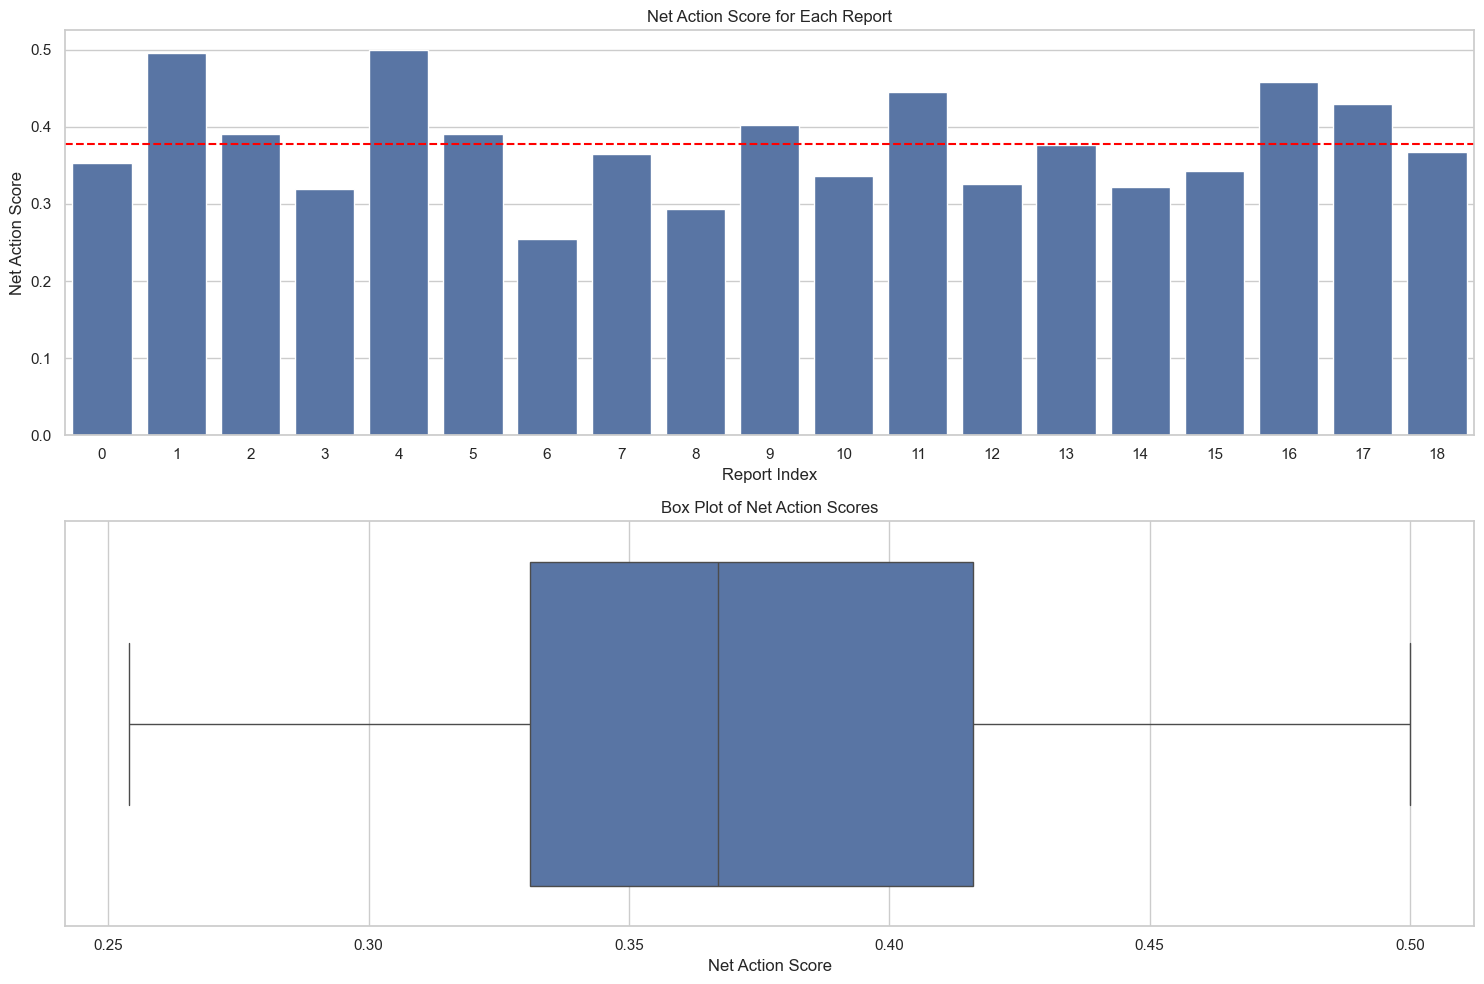

In [13]:
#using sns plot the net action score for each report as a bar plot, along with the average net action score
#in the side plot the box plot of the net action scores
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 10))

# Bar plot for net action scores
ax1 = plt.subplot(2, 1, 1)
sns.barplot(x=range(len(net_action_scores)), y=net_action_scores, ax=ax1)
ax1.axhline(np.mean(net_action_scores), color='red', linestyle='--')
            #label='Average Net Action Score ({:.2f})'.format(np.mean(net_action_scores)))
ax1.set_title('Net Action Score for Each Report')
ax1.set_xlabel('Report Index')
ax1.set_ylabel('Net Action Score')

# Box plot for net action scores
ax2 = plt.subplot(2, 1, 2)
sns.boxplot(x=net_action_scores, ax=ax2)
ax2.set_title('Box Plot of Net Action Scores')
ax2.set_xlabel('Net Action Score')

plt.tight_layout()
plt.show()

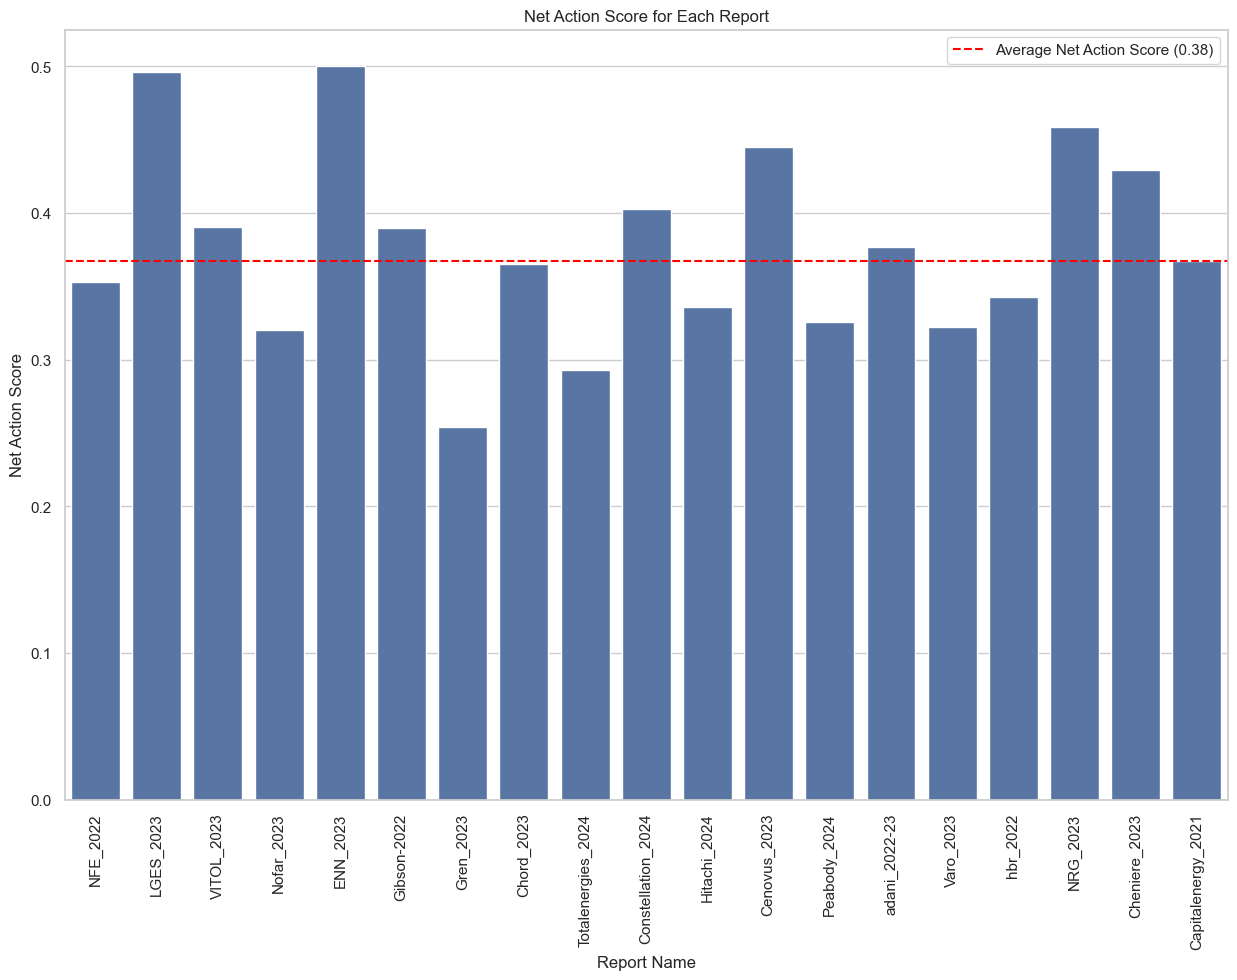

In [25]:
#plot the net action score for each report in the dataframe df_scores_new
plt.figure(figsize=(15, 10))
ax = sns.barplot(x="report", y="net_action_score", data=df_scores_new)
ax.axhline(np.median(net_action_scores), color='red', linestyle='--', label='Average Net Action Score ({:.2f})'.format(np.mean(net_action_scores)))
ax.set_title('Net Action Score for Each Report')
ax.set_xlabel('Report Name')
ax.set_ylabel('Net Action Score')
plt.xticks(rotation=90)
plt.legend()

In [26]:
#what is the standard deviation of the net action scores
std_dev = np.std(net_action_scores)
print("standard deviation: ", std_dev)

standard deviation:  0.06449072571869881


In [ ]:
#find the reports in the dataframe who are above 2 standard deviations from the mean
#add a column greenwashing to the dataframe df_scores_new
df_scores_new["greenwashing"] = df_scores_new["net_action_score"].apply(lambda x: "yes" if x < np.mean(net_action_scores) - std_dev else "no")

In [36]:
df_scores_new

,pdf_path,net_action_score,report,greenwashing
0,/Users/heenalpatel/Documents/esg_nlp/gw scores...,0.353198,NFE_2022,no
1,/Users/heenalpatel/Documents/esg_nlp/gw scores...,0.496052,LGES_2023,no
2,/Users/heenalpatel/Documents/esg_nlp/gw scores...,0.390187,VITOL_2023,no
3,/Users/heenalpatel/Documents/esg_nlp/gw scores...,0.319946,Nofar_2023,no
4,/Users/heenalpatel/Documents/esg_nlp/gw scores...,0.500000,ENN_2023,no
5,/Users/heenalpatel/Documents/esg_nlp/gw scores...,0.390071,Gibson-2022,no
6,/Users/heenalpatel/Documents/esg_nlp/gw scores...,0.253968,Gren_2023,yes
7,/Users/heenalpatel/Documents/esg_nlp/gw scores...,0.365180,Chord_2023,no
8,/Users/heenalpatel/Documents/esg_nlp/gw scores...,0.293219,Totalenergies_2024,yes
9,/Users/heenalpatel/Documents/esg_nlp/gw scores...,0.402439,Constellation_2024,no


In [44]:
df_scores = df_scores_new[["report", "net_action_score", "greenwashing"]]
df_scores

,report,net_action_score,greenwashing
0,NFE_2022,0.353198,no
1,LGES_2023,0.496052,no
2,VITOL_2023,0.390187,no
3,Nofar_2023,0.319946,no
4,ENN_2023,0.500000,no
5,Gibson-2022,0.390071,no
6,Gren_2023,0.253968,yes
7,Chord_2023,0.365180,no
8,Totalenergies_2024,0.293219,yes
9,Constellation_2024,0.402439,no


In [41]:
df_scores.rename(columns={"net_action_score": "score"}, inplace=True)
df_scores

/var/folders/qg/9zy2dl9s4vz2qxjxh5xtzwm80000gn/T/ipykernel_22191/2009005057.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scores.rename(columns={"net_action_score": "score"}, inplace=True)


,report,score,greenwashing
0,NFE_2022,0.353198,no
1,LGES_2023,0.496052,no
2,VITOL_2023,0.390187,no
3,Nofar_2023,0.319946,no
4,ENN_2023,0.500000,no
5,Gibson-2022,0.390071,no
6,Gren_2023,0.253968,yes
7,Chord_2023,0.365180,no
8,Totalenergies_2024,0.293219,yes
9,Constellation_2024,0.402439,no


In [45]:
# #save the dataframe df_scores_new to a csv file
df_scores.to_csv("GW output/greenwashing_reports.csv", index=False)

In [48]:
#find the reports with low net action scores
with open("output/pdf_data.json", 'r') as f:
    data = json.load(f)
    for item in data:
        if item["net_action_score"] < 0.35:
            print(item["pdf_path"], item["net_action_score"])

../data/2024-gore-street-energy-storage-fund-esg-and-sustainability-report.pdf 0.3134328358208955
../data/betterenergy_2021.pdf 0.2725903614457831
../SR/Totalenergies_2024.pdf 0.2932187201528176
../SR/NRG_2021.pdf 0.33918128654970764


## new report (user input)

- if the score is lower than mean 0.3 (?) then maybe GW

In [2]:
#open GW output/greenwashing_reports.csv
gw = pd.read_csv("GW output/greenwashing_reports.csv")
gw

,report,net_action_score,greenwashing
0,NFE_2022,0.353198,no
1,LGES_2023,0.496052,no
2,VITOL_2023,0.390187,no
3,Nofar_2023,0.319946,no
4,ENN_2023,0.500000,no
5,Gibson-2022,0.390071,no
6,Gren_2023,0.253968,yes
7,Chord_2023,0.365180,no
8,Totalenergies_2024,0.293219,yes
9,Constellation_2024,0.402439,no


In [4]:
#find the mean 
mean_score = gw["net_action_score"].mean()
print("mean score: ", mean_score)

#find 2std deviation from the mean
std_dev = gw["net_action_score"].std()
print("standard deviation: ", std_dev)

print("mean - 2 std deviation: ", mean_score - 2*std_dev)

mean score:  0.37727092555709474
standard deviation:  0.06625792211366308
mean - 2 std deviation:  0.2447550813297686
